In [2]:
import numpy 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

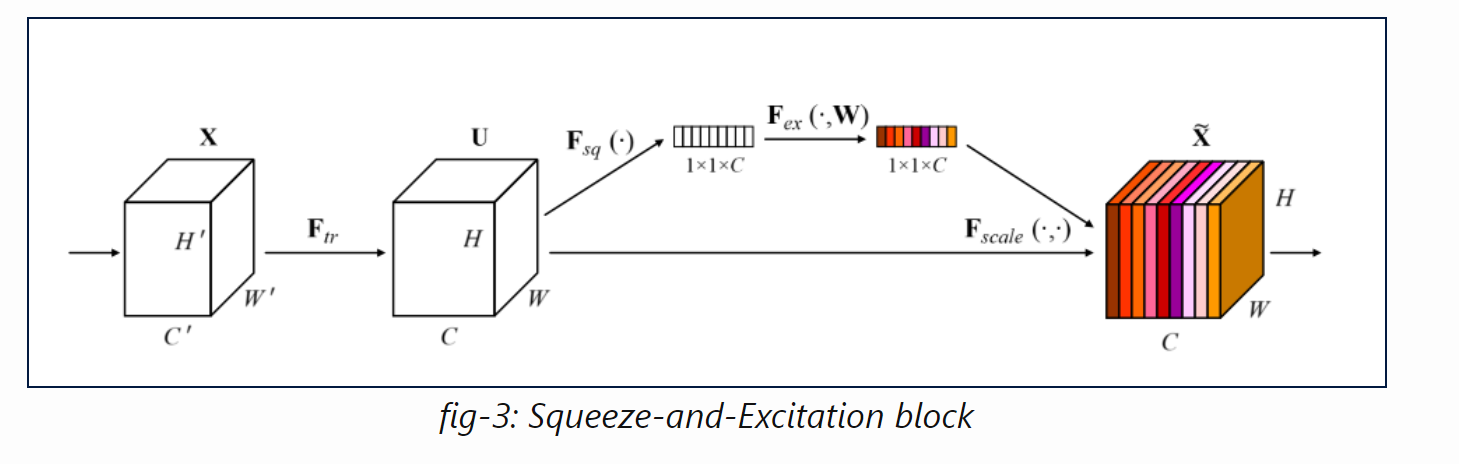

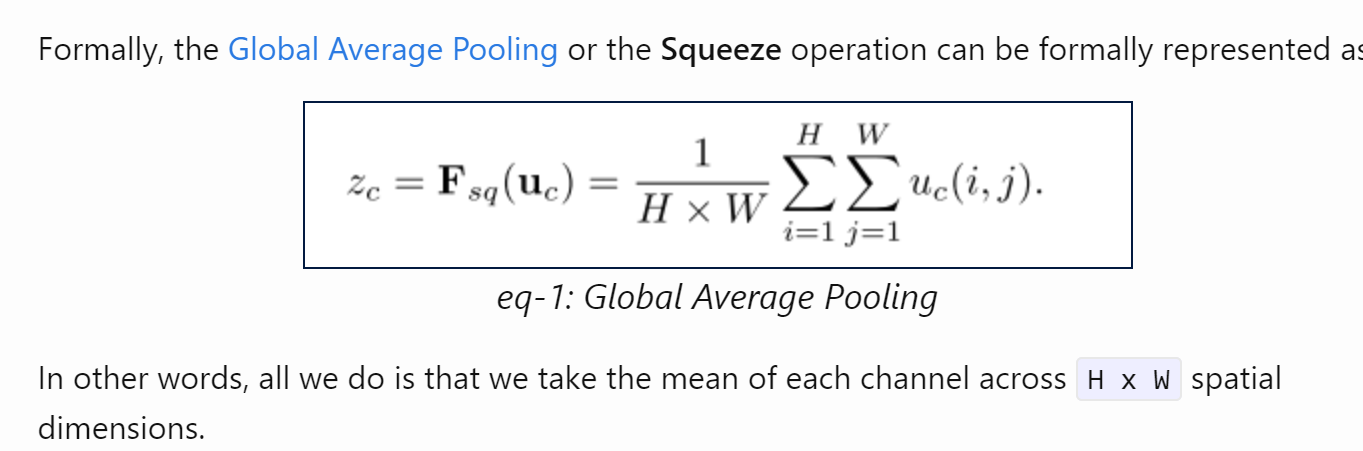

In [6]:
batch_size = 16
inp_channels = 64
inp_width = 128
inp_height = 128

test_input = torch.rand((batch_size, inp_channels, inp_width, inp_height))

In [7]:
squeeze = nn.AdaptiveAvgPool2d(1)
squeeze(test_input).shape

torch.Size([16, 64, 1, 1])

In [8]:
squeeze_output = squeeze(test_input).view(batch_size, inp_channels)
squeeze_output.shape

torch.Size([16, 64])

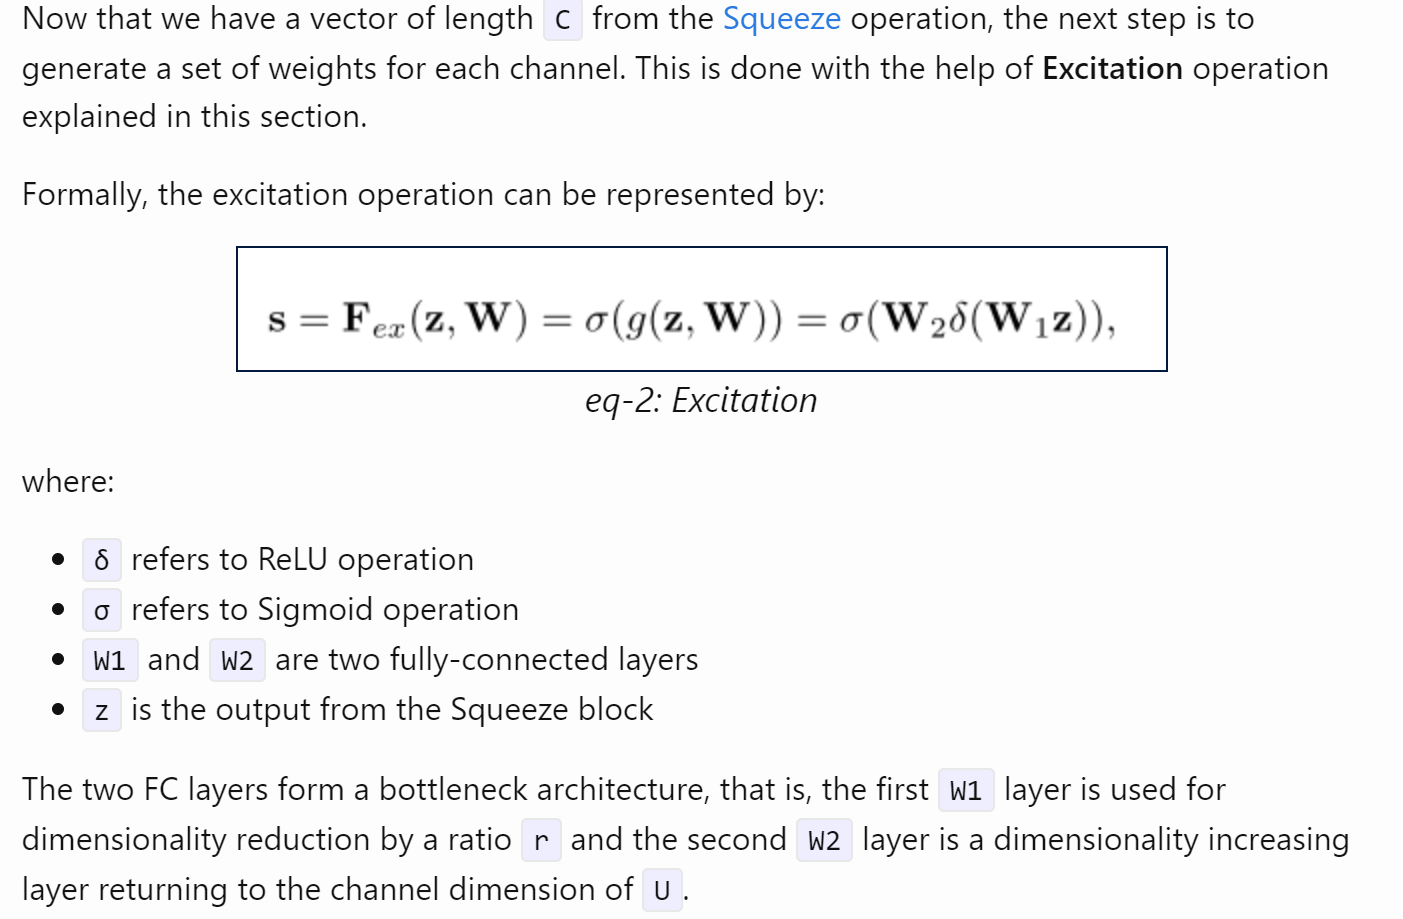

In [13]:
reduct = 16
excitation = nn.Sequential(
            nn.Linear(inp_channels, inp_channels // reduct, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(inp_channels// reduct, inp_channels, bias=False),
            nn.Sigmoid()
            )

excitation_out = excitation(squeeze_output)
excitation_out.shape

torch.Size([16, 64])

In [15]:
excitation_out = excitation_out.view(batch_size, inp_channels, 1, 1)
excitation_out.shape

torch.Size([16, 64, 1, 1])

In [17]:
(test_input * excitation_out.expand_as(test_input)).shape

torch.Size([16, 64, 128, 128])

In [19]:
class SE_Block(nn.Module):
    "credits: https://github.com/moskomule/senet.pytorch/blob/master/senet/se_module.py#L4"
    def __init__(self, channels, ratio=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input_):
        batch_size, channels, _, _ = input_.shape
        squeeze_out = self.squeeze(input_).view(batch_size, channels)
        excitation_out = self.excitation(squeeze_out).view(batch_size, channels, 1, 1)
        return input_ * excitation_out.expand_as(input_)

In [20]:
se_block = SE_Block(channels=64, ratio=16)
se_block(test_input).shape

torch.Size([16, 64, 128, 128])

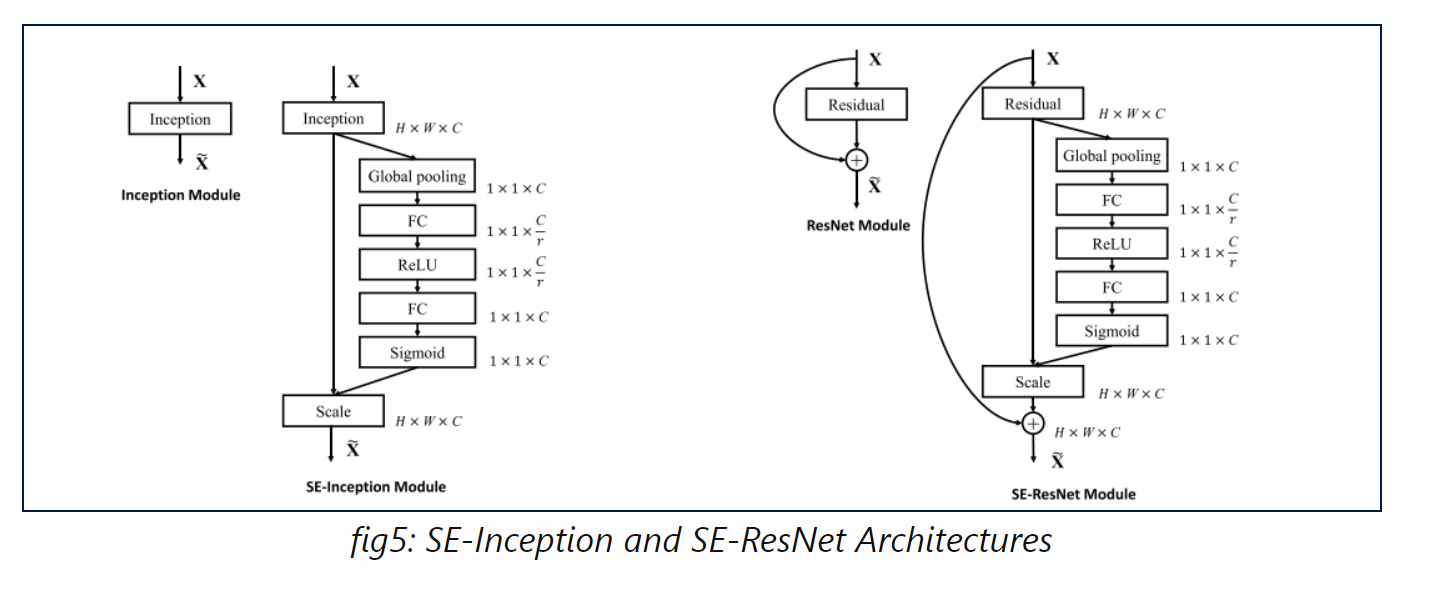

In [42]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [43]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

we update the forward to insert the SE block operation as in fig-6:

In [44]:
class SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, r=16):
        super(SEBasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride
        # add SE block
        self.se = SE_Block(planes, r)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        # add SE operation
        out = self.se(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

For ResNet-50 and above, we perform the same steps for ```Bottleneck``` architecture. First, we copy the ```Bottleneck``` class

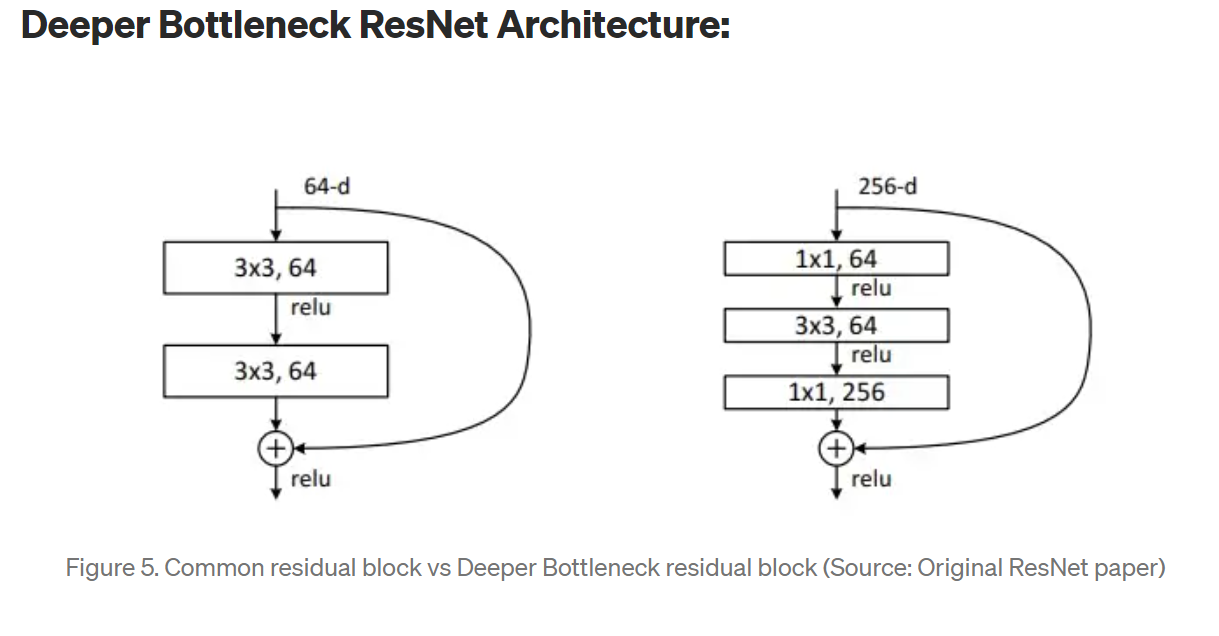

In [45]:
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [99]:
class SEBottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, r=16):
        super(SEBottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        
        if downsample is None:
            downsample = conv3x3(inplanes, planes * self.expansion)
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        # Add SE block
        self.se = SE_Block(planes * self.expansion, r)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        # Add SE operation
        out = self.se(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [100]:
inp_channels = 16
out_channels = 64
test_input = torch.rand((32, inp_channels, 128, 128))
downsample = conv3x3(inp_channels, inp_channels*4)
sebottle = SEBottleneck(inp_channels, out_channels)
sebottle(test_input).shape

torch.Size([32, 256, 128, 128])

In [51]:
from torchvision.models import ResNet

In [101]:
def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    return model

In [104]:
test_input = torch.rand((32, 3, 128, 128))

In [102]:
def se_resnet18(pretrained=False, progress=True, **kwargs):
    return _resnet('resnet18', SEBasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

In [96]:
resnet_18 = se_resnet18()
resnet_18(test_input).shape

torch.Size([32, 1000])

In [97]:
def se_resnet34(pretrained=False, progress=True, **kwargs):
    return _resnet('resnet34', SEBasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)

resneXt_34 = se_resnet34()
resneXt_34(test_input).shape

torch.Size([32, 1000])

In [105]:
def se_resnet50(pretrained=False, progress=True, **kwargs):
    return _resnet('resnet50', SEBottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)

resneXt_50 = se_resnet50()
resneXt_50(test_input).shape

torch.Size([32, 1000])